In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/EE698V/

Mounted at /content/gdrive
/content/gdrive/MyDrive/EE698V


In [2]:
NUM = 6 # Model number
epochs = 250
PATIENCE = 10
row_len = 513 # Number of columns: 1 + n_fft/2
col_len = 50

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import config, distribute
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

In [4]:
gpus = config.list_physical_devices('GPU');
print(gpus)

if len(gpus) == 1:
    strategy = distribute.OneDeviceStrategy(device="/gpu:0")
else:
    strategy = distribute.MirroredStrategy()

config.optimizer.set_experimental_options({"auto_mixed_precision": True})

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

  for i, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    axes[i].plot(history.epoch, history.history[metric], color = colors[0], label = 'Train')
    axes[i].plot(history.epoch, history.history['val_' + metric], color = colors[0], linestyle = "--", label = 'Val')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(name)
    axes[i].legend()

def build_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (7, 3), strides = 2, activation = 'relu', input_shape = (row_len, col_len, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (4, 2)))
    model.add(Conv2D(64, kernel_size = (7, 3), strides = 2, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (4, 1)))
    model.add(Conv2D(128, kernel_size = 3, strides = 2, activation = 'relu'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(n_classes, activation = 'softmax'))

    model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [6]:
train = pd.read_csv("labels_train.csv")

LABELS = list(train['class'].unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train["label_idx"] = train["class"].apply(lambda x : label_idx[x])
n_classes = len(train["class"].unique())

X_train = np.load("train_data/input_data_slices.npy")
Y_train = np.load("train_data/input_target_slices.npy")

MEAN = np.mean(X_train, axis = 0)
STD = np.std(X_train, axis = 0)
X_train = (X_train - MEAN)/STD

normalize = [MEAN, STD]
np.save("models/normalize_slices", normalize)

In [7]:
with strategy.scope():
    model = build_model()

X_t, X_val, Y_t, Y_val = train_test_split(X_train, Y_train, test_size = 0.05)

checkpoint = ModelCheckpoint('models/best_slices_%d.h5'%NUM, monitor = 'val_accuracy',  mode = 'max', verbose = 0, save_best_only = True)
early = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = PATIENCE, verbose = 0)
annealer = LearningRateScheduler(lambda x : 1e-3*(0.95**x))
callbacks_list = [checkpoint, early, annealer]

history = model.fit(X_t, Y_t, validation_data = (X_val, Y_val), epochs = epochs, callbacks = callbacks_list, verbose = 0, batch_size = 32)

Train accuracy = 0.94082, Validation accuracy = 0.94880


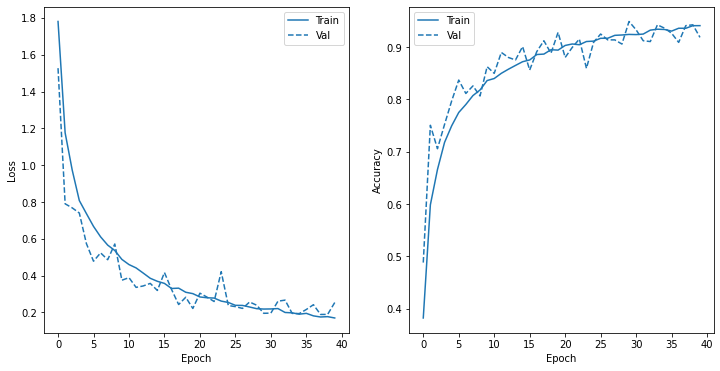

In [8]:
plot_metrics(history)
print("Train accuracy = {0:.5f}, Validation accuracy = {1:.5f}".format(max(history.history['accuracy']), max(history.history['val_accuracy'])))